In [593]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [594]:
import numpy as np
import pandas as pd

In [595]:
#import datetime as dt
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import re

# Reflect Tables into SQLAlchemy ORM

In [596]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, select

In [597]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [598]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [599]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [600]:
# Save references to each table

Measurement = Base.classes.measurement
Station     = Base.classes.station


In [601]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [602]:
#Get to know the tables and the columns.

inspector = inspect(engine)
inspector.get_table_names()


columns = inspector.get_columns('measurement')
print('measurement columns: ')
for c in columns:
    print(c['name'], c["type"])

print('')
print('Sample Data')

results = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).limit(10).all()

for record in results:
    print(record)

print('')  

columns1 = inspector.get_columns('station')
print('measurement columns: ')
for c in columns1:
    print(c['name'], c["type"])


results_station = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).limit(10).all()

print('')
print('Sample Data')

for record_station in results_station:
    print(record_station)


measurement columns: 
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Sample Data
(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
(6, 'USC00519397', '2010-01-07', 0.06, 70.0)
(7, 'USC00519397', '2010-01-08', 0.0, 64.0)
(8, 'USC00519397', '2010-01-09', 0.0, 68.0)
(9, 'USC00519397', '2010-01-10', 0.0, 73.0)
(10, 'USC00519397', '2010-01-11', 0.01, 64.0)

measurement columns: 
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

Sample Data
(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, 

(1, '2010-01-01', 0.08, 65.0, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2725, '2010-01-01', 0.28, 67.0, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
<class 'sqlalchemy.engine.row.Row'>
<class 'str'>
Last data point is : 2017-08-23 00:00:00
A year ago is : 2016-08-23 00:00:00


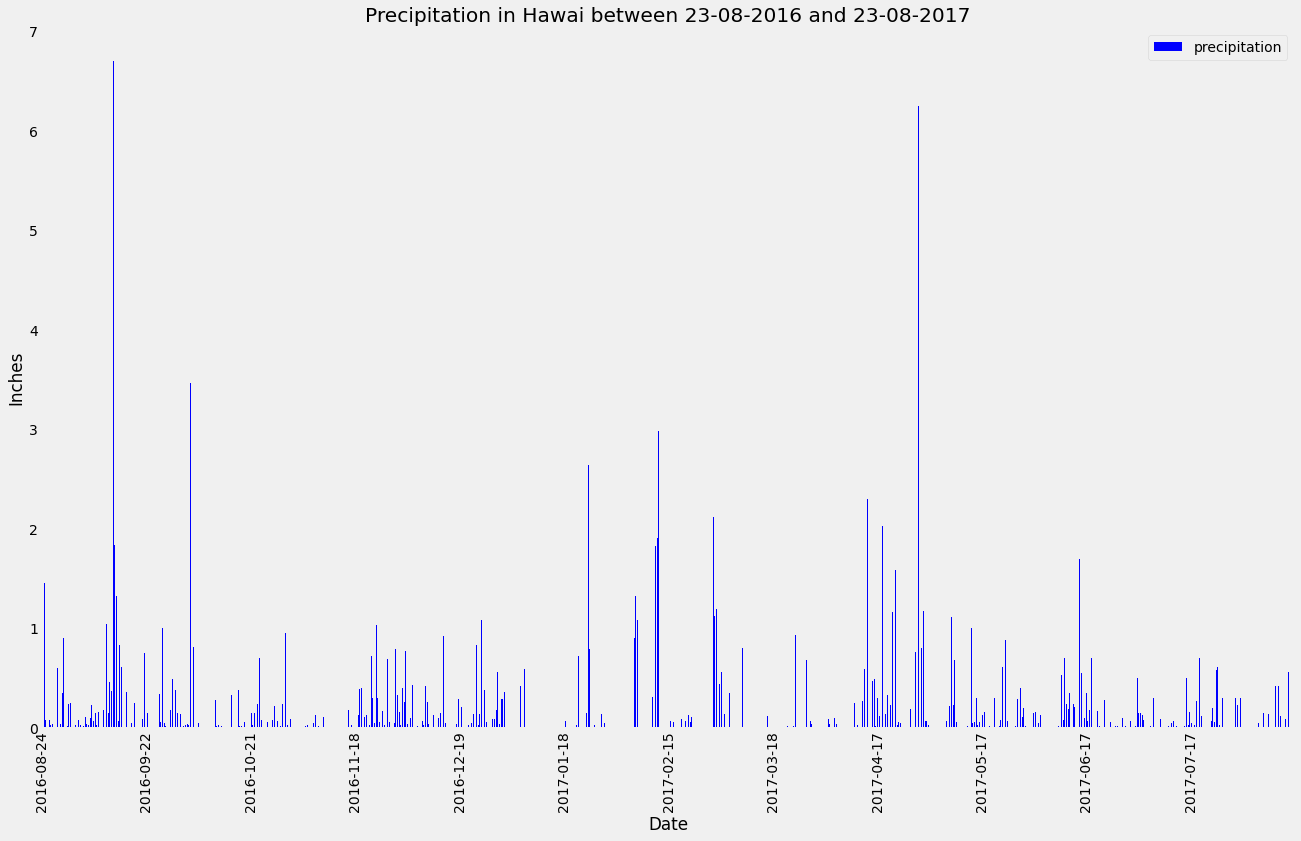

In [603]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

sel = [Measurement.id, Measurement.date, Measurement.prcp, Measurement.tobs ,Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
joined_query = session.query(*sel).filter(Measurement.station == Station.station).order_by(Measurement.date).limit(2).all()

#to see a sample output to verify the data
for record in joined_query:
    print(record)


# **********************************************************************
# Calculate the date 1 year ago from the last data point in the database

session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(type(session.query(Measurement.date).order_by(Measurement.date.desc()).first()) )
#type is sqlalchemy.engine.row.Row

for u in session.query(Measurement.date).order_by(Measurement.date.desc()).first():    
    print(type(u))
    enddate = u
    #row is converted to string

# I couldn't directly convert row to datetime. I used for loop to convert the last date to a string variable. 

datetime_object = datetime.strptime(enddate, '%Y-%m-%d')
print(f'Last data point is : {datetime_object}')

yr_ago = datetime_object - relativedelta(years=1)
print(f'A year ago is : {yr_ago}')


# **********************************************************************
# Perform a query to retrieve the data and precipitation scores

sel_graph = [Measurement.date, Measurement.prcp]

results = []
results = session.query(*sel_graph).filter(Measurement.station == Station.station).\
                                    filter(Measurement.date >= yr_ago).all()


# **********************************************************************
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(results, columns=['date','precipitation'])
prcp_df.set_index(prcp_df['date'], inplace=True)

prcp_df = prcp_df.sort_index()
prcp_df = prcp_df.dropna()


# Use Pandas Plotting with Matplotlib to plot the data

# There are multiple entries for the same day, from different stations. It makes more sense to take the mean data, because we are looking at all Hawaii
# However the graph in the homework description is set to all data, therefore I rollbacked group by.
# multi_plot_df = prcp_df.groupby(by=prcp_df.index).mean()

s_enddate = datetime_object.strftime("%d-%m-%Y")
s_startdate = yr_ago.strftime("%d-%m-%Y")

multi_plot = prcp_df.plot(kind="bar", figsize=(20,12), color='b')
multi_plot.locator_params(axis='x', nbins=12)

multi_plot.set_title(f'Precipitation in Hawai between {s_startdate} and {s_enddate}')
multi_plot.set_xlabel('Date')
multi_plot.set_ylabel('Inches')

multi_plot.grid()



In [604]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [605]:
# Design a query to show how many stations are available in this dataset?
counts = session.query(func.count(Station.station)).scalar() 

print(f'There are {counts} in the dataset')


There are 9 in the dataset


In [606]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel_count = [Station.id, Station.station ,Station.name ,func.count(Measurement.id)]

station_counts = session.query(*sel_count).\
            filter(Measurement.station == Station.station).\
            group_by(Station.station,Station.name).\
            order_by(func.count(Measurement.id).desc()).all()

station_counts_df = pd.DataFrame(station_counts, columns=['Station ID', 'Station', 'Station Name', 'Record Count']) 

Most_active_Station = station_counts_df.iloc[0]

print('Most active stations in Hawai is: ')
print(f'ID  : {Most_active_Station["""Station ID"""]}')
print(f'Code: {Most_active_Station["""Station"""]}')
print(f'Name: {Most_active_Station["""Station Name"""]}')
print(f'Row Count: {Most_active_Station["""Record Count"""]}')

print('')
print('The row count per stations are: ')
station_counts_df.head()





Most active stations in Hawai is: 
ID  : 7
Code: USC00519281
Name: WAIHEE 837.5, HI US
Row Count: 2772

The row count per stations are: 


,Station ID,Station,Station Name,Record Count
0,7,USC00519281,"WAIHEE 837.5, HI US",2772
1,1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,2,USC00513117,"KANEOHE 838.1, HI US",2709
3,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612


In [607]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel_values = [Station.id, 
              Station.station ,
              Station.name ,
              func.max(Measurement.tobs), 
              func.min(Measurement.tobs),
              func.avg(Measurement.tobs)]
   
station_stats = session.query(*sel_values).\
                filter(Station.id == f'{Most_active_Station["""Station ID"""]}').\
                filter(Measurement.station == Station.station).\
                group_by(Station.id,Station.station,Station.name).all()

station_stats_df = pd.DataFrame(station_stats, columns=['Station ID', 'Station', 'Station Name', 'Highest Temperature','Lowest Temperature','Average Temperature']) 



print('The stats for the most active station is : ')
print('')

station_stats_df.head()
   


The stats for the most active station is : 



,Station ID,Station,Station Name,Highest Temperature,Lowest Temperature,Average Temperature
0,7,USC00519281,"WAIHEE 837.5, HI US",85.0,54.0,71.663781


Text(0.5, 1.0, 'Temperature observation for USC00519281 - WAIHEE 837.5, HI US')

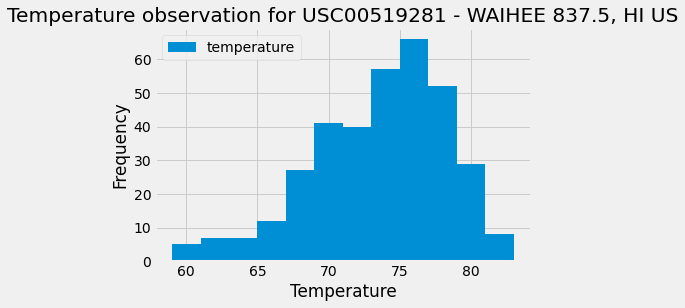

In [608]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel_hist = [Measurement.tobs]

results = []
results = session.query(*sel_hist).filter(Measurement.station == f'{Most_active_Station["""Station"""]}').\
                                   filter(Measurement.date >= yr_ago).all()



hist_df = pd.DataFrame(results, columns=['temperature'])

x_title = f'Temperature observation for {Most_active_Station["""Station"""]} - {Most_active_Station["""Station Name"""]}'

hist_plot = hist_df.plot(kind='hist', bins=12)
hist_plot.set_xlabel('Temperature')
hist_plot.set_ylabel('Frequency')
hist_plot.set_title(x_title)


## Bonus Challenge Assignment

In [609]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [610]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

vacation_start_date = '2017-08-17'
vacation_end_date   = '2017-08-25'

calc_start_date = datetime.strptime(vacation_start_date, '%Y-%m-%d') - relativedelta(years=1)
calc_start_date = calc_start_date.strftime( '%Y-%m-%d')

calc_end_date = datetime.strptime(vacation_end_date, '%Y-%m-%d') - relativedelta(years=1)
calc_end_date = calc_end_date.strftime( '%Y-%m-%d')

print(f'Selected vacation dates are: {vacation_start_date} - {vacation_end_date}')

print(f'Temperature stats for the same period a year ago ({calc_start_date} - {calc_end_date}) : ')


s = str((calc_temps(calc_start_date, calc_end_date))[0]).split(',')

min_temp=s[0].replace('(', '')
print(f'The minimum temperature is : {min_temp}')

avg_temp=s[1].replace(' ', '').replace(' ','')
print(f'The average temperature is : {avg_temp}')

max_temp = s[2].replace(')', '').replace(' ','')
print(f'The maximum temperature is : {max_temp}')




Selected vacation dates are: 2017-08-17 - 2017-08-25
Temperature stats for the same period a year ago (2016-08-17 - 2016-08-25) : 
The minimum temperature is : 72.0
The average temperature is : 78.23728813559322
The maximum temperature is : 82.0


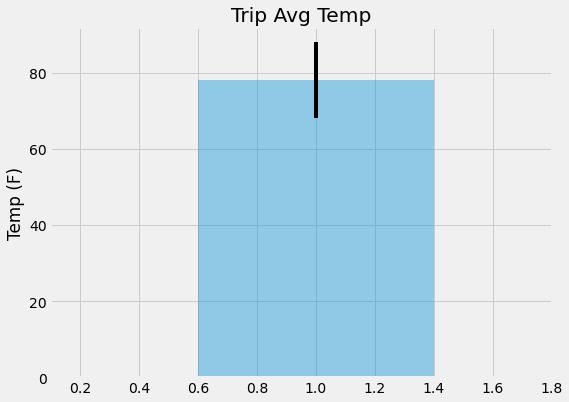

In [611]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

mean      = float(avg_temp)
peak2peak = float(max_temp) - float(min_temp)
x_pos     = 1    

plt.figure(figsize=(8,6))


plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(.10 , 1.8)
plt.ylim(0,round(float(max_temp) + 10))

mytrip_temp = plt.bar(x_pos, mean, yerr=peak2peak,  align="center", alpha=0.4)

In [612]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel_vacation = [Station.station ,
                Station.name ,
                Station.latitude ,
                Station.longitude ,
                Station.elevation ,
                func.sum(Measurement.prcp)]
   
vacation_stats = session.query(*sel_vacation).\
                 filter(Measurement.date >= calc_start_date).\
                 filter(Measurement.date <= calc_end_date).\
                 filter(Measurement.station == Station.station).\
                 group_by(Station.station ,
                          Station.name ,
                          Station.latitude ,
                          Station.longitude ,
                          Station.elevation ,).\
                 order_by(func.sum(Measurement.prcp).desc()).all()

station_stats_df = pd.DataFrame(vacation_stats, columns=['Station', 'Station Name', 'Latitude','Longtitude','Elevation','Total Rainfall']) 
(station_stats_df.head())


,Station,Station Name,Latitude,Longtitude,Elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.55
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,7.15
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.81
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.41
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.26


In [613]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [614]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

vacation_start_date = '2017-08-17'
vacation_end_date   = '2017-08-25'

calc_start_date = datetime.strptime(vacation_start_date, '%Y-%m-%d') - relativedelta(years=1)
calc_end_date   = datetime.strptime(vacation_end_date, '%Y-%m-%d') - relativedelta(years=1)


# Use the start and end date to create a range of dates


def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = calc_start_date
end_dt = calc_end_date

results = []
fulldates = []
for dt in daterange(start_dt, end_dt):
    sdate = dt.strftime("%Y-%m-%d")
    results.append(sdate[5:12])
    fulldates.append(sdate)

# Stip off the year and save a list of %m-%d strings
print(results)

min_series = []
avg_series = []
max_series = []

# Loop through the list of %m-%d strings and calculate the normals for each date
for dt in results:
  
    res = str(daily_normals(dt)[0]).split(',')

    min_temp=res[0].replace('(', '')
    avg_temp=res[1].replace(' ', '').replace(' ','')
    max_temp = res[2].replace(')', '').replace(' ','')

    min_series.append(min_temp)
    avg_series.append(avg_temp)
    max_series.append(max_temp)



['08-17', '08-18', '08-19', '08-20', '08-21', '08-22', '08-23', '08-24', '08-25']


In [615]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(
                                {'Trip Date': fulldates,
                                 'Minimum Temperature': min_series,
                                 'Average Temperature': avg_series,
                                 'Maximum Temperature': max_series
                                })
daily_normals_df.set_index('Trip Date')
daily_normals_df.head()


,Trip Date,Minimum Temperature,Average Temperature,Maximum Temperature
0,2016-08-17,69.0,76.125,83.0
1,2016-08-18,70.0,76.92307692307692,84.0
2,2016-08-19,69.0,75.94642857142857,85.0
3,2016-08-20,68.0,76.45283018867924,82.0
4,2016-08-21,67.0,76.4,83.0


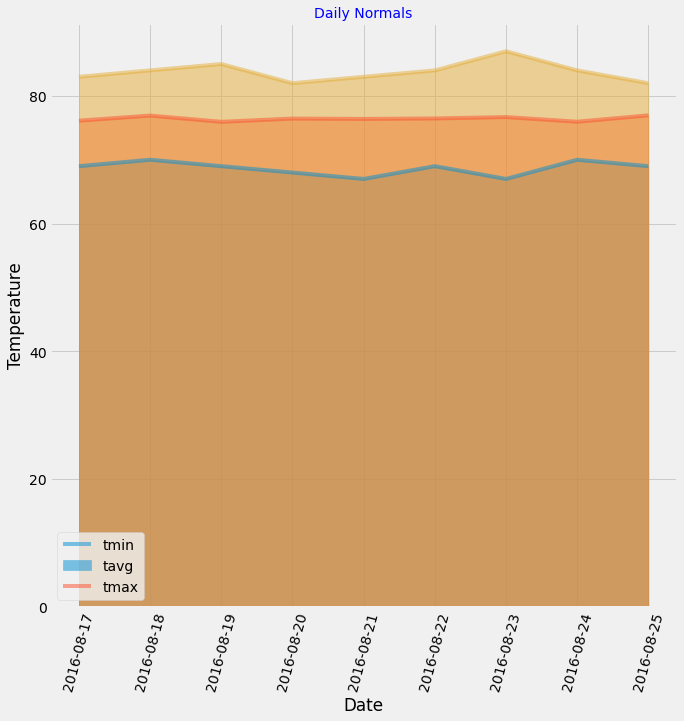

In [616]:
# Plot the daily normals as an area plot with `stacked=False`

daily_normals_df["Minimum Temperature"] = pd.to_numeric(daily_normals_df["Minimum Temperature"])
daily_normals_df["Average Temperature"] = pd.to_numeric(daily_normals_df["Average Temperature"])
daily_normals_df["Maximum Temperature"] = pd.to_numeric(daily_normals_df["Maximum Temperature"])

daily_normals_df.plot(kind='area', stacked=False, alpha=0.5,   figsize=(10, 10))

plt.xticks(np.arange(len(daily_normals_df.index)), daily_normals_df['Trip Date'], rotation=75)
plt.title("Daily Normals", color="blue", size=14, loc="center")
plt.ylabel("Temperature")
plt.xlabel("Date")

[ax.legend(('tmin', 'tavg', 'tmax')) for ax in plt.gcf().axes]


